<a href="https://colab.research.google.com/github/atickoo741-art/iv-short-horizon-analysis/blob/main/project_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
#select stocks

import os
import math
import time
import warnings
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")
plt.rcParams["figure.dpi"] = 120

DATA_DIR = "data_earnings_iv_project"
os.makedirs(DATA_DIR, exist_ok=True)

@dataclass
class UniverseConfig:
    tickers: List[str]
    min_price: float = 5.0
    min_avg_dollar_vol: float = 25_000_000  # proxy liquidity using shares*price avg (free)
    lookback_days: int = 60

def get_price_history(ticker: str, lookback_days: int = 60) -> pd.DataFrame:
    df = yf.download(ticker, period=f"{lookback_days}d", interval="1d", auto_adjust=True, progress=False)
    if df is None or df.empty:
        return pd.DataFrame()
    df = df.reset_index().rename(columns=str.lower)
    return df

def avg_dollar_volume(price_df: pd.DataFrame) -> float:
    # dollar volume proxy: close * volume average
    if price_df.empty or "close" not in price_df.columns or "volume" not in price_df.columns:
        return 0.0
    return float((price_df["close"] * price_df["volume"]).tail(30).mean())

def filter_universe(cfg: UniverseConfig) -> pd.DataFrame:
    rows = []
    for t in cfg.tickers:
        px = get_price_history(t, cfg.lookback_days)
        if px.empty:
            continue
        last_close = float(px["close"].iloc[-1])
        adv = avg_dollar_volume(px)
        ok = (last_close >= cfg.min_price) and (adv >= cfg.min_avg_dollar_vol)
        rows.append({"ticker": t, "last_close": last_close, "avg_dollar_vol": adv, "keep": ok})
    uni = pd.DataFrame(rows).sort_values(["keep", "avg_dollar_vol"], ascending=[False, False])
    return uni

# Example universe (edit freely)
cfg = UniverseConfig(
    tickers=["NVDA", "AAPL","GOOGL", "AMZN", "JPM"],
    min_price=5,
    min_avg_dollar_vol=25_000_000,
    lookback_days=120
)

universe_df = filter_universe(cfg)
display(universe_df)

selected = universe_df.loc[universe_df["keep"], "ticker"].tolist()
print("Selected tickers:", selected)


,ticker,last_close,avg_dollar_vol,keep
0,NVDA,188.119995,3.343669e+10,True
2,GOOGL,316.540009,1.172767e+10,True
1,AAPL,267.260010,1.170450e+10,True
3,AMZN,233.059998,8.780991e+09,True
4,JPM,334.040009,2.948551e+09,True


Selected tickers: ['NVDA', 'GOOGL', 'AAPL', 'AMZN', 'JPM']


In [23]:
#earnings events pulled from csv, expiration = next friday after event

import os
import pandas as pd
from datetime import timedelta

EARNINGS_CSV = os.path.join(DATA_DIR, "earnings_dates.csv")

def load_earnings_dates(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df["ticker"] = df["ticker"].str.upper()
    df["earnings_date"] = pd.to_datetime(df["earnings_date"]).dt.normalize()
    return df

def first_friday_after(date: pd.Timestamp) -> pd.Timestamp:
    d = date + timedelta(days=1)
    while d.weekday() != 4:  # Monday=0, Friday=4
        d += timedelta(days=1)
    return d

# Load earnings
earnings_df = load_earnings_dates(EARNINGS_CSV)

# Restrict to universe
earnings_df = earnings_df[earnings_df["ticker"].isin(selected)].copy()

# Build events table
earnings_df["aligned_expiry"] = earnings_df["earnings_date"].apply(first_friday_after)

events_df = (
    earnings_df
    .sort_values(["ticker", "earnings_date"])
    .reset_index(drop=True)
)

print(f"Identified {len(events_df)} earnings events.")
display(events_df)


Identified 60 earnings events.


,ticker,earnings_date,aligned_expiry
0,AAPL,2022-01-27,2022-01-28
1,AAPL,2022-04-28,2022-04-29
2,AAPL,2022-07-28,2022-07-29
3,AAPL,2022-10-27,2022-10-28
4,AAPL,2023-02-02,2023-02-03
5,AAPL,2023-05-04,2023-05-05
6,AAPL,2023-08-03,2023-08-04
7,AAPL,2023-11-02,2023-11-03
8,AAPL,2024-02-01,2024-02-02
9,AAPL,2024-05-02,2024-05-03


In [24]:
#define pre earnings window (14d)

from dataclasses import dataclass
from typing import Tuple

@dataclass
class WindowConfig:
    pre_days: int = 14

win_cfg = WindowConfig(pre_days=14)

def make_pre_earnings_window(earnings_date: pd.Timestamp,
                             pre_days: int) -> Tuple[pd.Timestamp, pd.Timestamp]:
    end = earnings_date.normalize()
    start = end - pd.Timedelta(days=pre_days)
    return start, end

if events_df.empty:
    print("No earnings events found. Check earnings_dates.csv.")
    events_df["window_start"] = pd.NaT
    events_df["window_end"] = pd.NaT
    events_df["obs_dates"] = [[] for _ in range(len(events_df))]
else:
    windows = events_df["earnings_date"].apply(
        lambda d: make_pre_earnings_window(d, win_cfg.pre_days)
    )

    events_df["window_start"] = windows.apply(lambda x: x[0])
    events_df["window_end"] = windows.apply(lambda x: x[1])

    def business_days_between(start: pd.Timestamp, end: pd.Timestamp):
        return list(pd.bdate_range(start, end))

    events_df["obs_dates"] = events_df.apply(
        lambda r: business_days_between(r["window_start"], r["window_end"]),
        axis=1
    )

display(events_df)


,ticker,earnings_date,aligned_expiry,window_start,window_end,obs_dates
0,AAPL,2022-01-27,2022-01-28,2022-01-13,2022-01-27,"[2022-01-13 00:00:00, 2022-01-14 00:00:00, 202..."
1,AAPL,2022-04-28,2022-04-29,2022-04-14,2022-04-28,"[2022-04-14 00:00:00, 2022-04-15 00:00:00, 202..."
2,AAPL,2022-07-28,2022-07-29,2022-07-14,2022-07-28,"[2022-07-14 00:00:00, 2022-07-15 00:00:00, 202..."
3,AAPL,2022-10-27,2022-10-28,2022-10-13,2022-10-27,"[2022-10-13 00:00:00, 2022-10-14 00:00:00, 202..."
4,AAPL,2023-02-02,2023-02-03,2023-01-19,2023-02-02,"[2023-01-19 00:00:00, 2023-01-20 00:00:00, 202..."
5,AAPL,2023-05-04,2023-05-05,2023-04-20,2023-05-04,"[2023-04-20 00:00:00, 2023-04-21 00:00:00, 202..."
6,AAPL,2023-08-03,2023-08-04,2023-07-20,2023-08-03,"[2023-07-20 00:00:00, 2023-07-21 00:00:00, 202..."
7,AAPL,2023-11-02,2023-11-03,2023-10-19,2023-11-02,"[2023-10-19 00:00:00, 2023-10-20 00:00:00, 202..."
8,AAPL,2024-02-01,2024-02-02,2024-01-18,2024-02-01,"[2024-01-18 00:00:00, 2024-01-19 00:00:00, 202..."
9,AAPL,2024-05-02,2024-05-03,2024-04-18,2024-05-02,"[2024-04-18 00:00:00, 2024-04-19 00:00:00, 202..."


In [26]:
#realized earnings moves

import yfinance as yf
import numpy as np
import pandas as pd

def realized_earnings_move(ticker: str, earnings_date: pd.Timestamp) -> float:
    """
    Absolute return from last close before earnings
    to first close after earnings (robust to yfinance quirks).
    """
    start = earnings_date - pd.Timedelta(days=7)
    end = earnings_date + pd.Timedelta(days=7)

    df = yf.download(
        ticker,
        start=start.date(),
        end=end.date(),
        auto_adjust=True,
        progress=False
    )

    if df is None or df.empty:
        return np.nan

    # Ensure Close is a Series (not DataFrame)
    close = df["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]

    close = close.dropna()
    if close.empty:
        return np.nan

    close.index = pd.to_datetime(close.index).normalize()

    # Last close on or before earnings
    before = close[close.index <= earnings_date]
    # First close after earnings
    after = close[close.index > earnings_date]

    if before.empty or after.empty:
        return np.nan

    p0 = float(before.iloc[-1])
    p1 = float(after.iloc[0])

    return abs(p1 / p0 - 1.0)

# Apply safely
events_df["realized_move"] = events_df.apply(
    lambda r: realized_earnings_move(r["ticker"], r["earnings_date"]),
    axis=1
)

events_df = events_df.dropna(subset=["realized_move"])
display(events_df.head())


,ticker,earnings_date,aligned_expiry,window_start,window_end,obs_dates,realized_move
0,AAPL,2022-01-27,2022-01-28,2022-01-13,2022-01-27,"[2022-01-13 00:00:00, 2022-01-14 00:00:00, 202...",0.069778
1,AAPL,2022-04-28,2022-04-29,2022-04-14,2022-04-28,"[2022-04-14 00:00:00, 2022-04-15 00:00:00, 202...",0.036605
2,AAPL,2022-07-28,2022-07-29,2022-07-14,2022-07-28,"[2022-07-14 00:00:00, 2022-07-15 00:00:00, 202...",0.032793
3,AAPL,2022-10-27,2022-10-28,2022-10-13,2022-10-27,"[2022-10-13 00:00:00, 2022-10-14 00:00:00, 202...",0.075553
4,AAPL,2023-02-02,2023-02-03,2023-01-19,2023-02-02,"[2023-01-19 00:00:00, 2023-01-20 00:00:00, 202...",0.024400


In [27]:
#expected moves

def expected_move_from_history(df: pd.DataFrame,
                               ticker: str,
                               asof_date: pd.Timestamp,
                               min_obs: int = 4) -> float:
    """
    Median absolute earnings move from prior events only.
    """
    hist = df[
        (df["ticker"] == ticker) &
        (df["earnings_date"] < asof_date)
    ]["realized_move"]

    if len(hist) < min_obs:
        return np.nan

    return hist.median()

events_df["expected_move"] = events_df.apply(
    lambda r: expected_move_from_history(
        events_df, r["ticker"], r["earnings_date"]
    ),
    axis=1
)

events_df = events_df.dropna(subset=["expected_move"])
display(events_df.head())


,ticker,earnings_date,aligned_expiry,window_start,window_end,obs_dates,realized_move,expected_move
4,AAPL,2023-02-02,2023-02-03,2023-01-19,2023-02-02,"[2023-01-19 00:00:00, 2023-01-20 00:00:00, 202...",0.024400,0.053191
5,AAPL,2023-05-04,2023-05-05,2023-04-20,2023-05-04,"[2023-04-20 00:00:00, 2023-04-21 00:00:00, 202...",0.046927,0.036605
6,AAPL,2023-08-03,2023-08-04,2023-07-20,2023-08-03,"[2023-07-20 00:00:00, 2023-07-21 00:00:00, 202...",0.048020,0.041766
7,AAPL,2023-11-02,2023-11-03,2023-10-19,2023-11-02,"[2023-10-19 00:00:00, 2023-10-20 00:00:00, 202...",0.005181,0.046927
8,AAPL,2024-02-01,2024-02-02,2024-01-18,2024-02-01,"[2024-01-18 00:00:00, 2024-01-19 00:00:00, 202...",0.005405,0.041766


In [28]:
#relative expectations

events_df["rel_expectation"] = (
    events_df["expected_move"] /
    events_df.groupby("ticker")["expected_move"].transform("median")
)

display(events_df[["ticker","earnings_date","expected_move","rel_expectation","realized_move"]].head())


,ticker,earnings_date,expected_move,rel_expectation,realized_move
4,AAPL,2023-02-02,0.053191,1.273562,0.024400
5,AAPL,2023-05-04,0.036605,0.876431,0.046927
6,AAPL,2023-08-03,0.041766,1.000000,0.048020
7,AAPL,2023-11-02,0.046927,1.123569,0.005181
8,AAPL,2024-02-01,0.041766,1.000000,0.005405


,bucket,count,mean,median,std
0,Very Low,8,0.036596,0.035930,0.034012
1,Low,8,0.079590,0.076835,0.053185
2,Neutral,8,0.069024,0.038096,0.079457
3,High,9,0.033475,0.027474,0.033210
4,Very High,7,0.028763,0.024104,0.027105


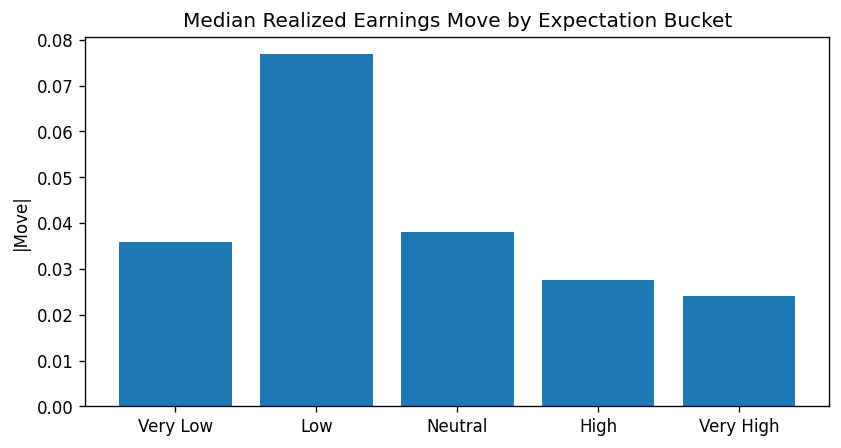

In [29]:
#bucket analysis

events_df["bucket"] = pd.qcut(
    events_df["rel_expectation"],
    q=5,
    labels=["Very Low","Low","Neutral","High","Very High"]
)

bucket_stats = (
    events_df
    .groupby("bucket")["realized_move"]
    .agg(["count","mean","median","std"])
    .reset_index()
)

display(bucket_stats)

import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
plt.bar(bucket_stats["bucket"], bucket_stats["median"])
plt.title("Median Realized Earnings Move by Expectation Bucket")
plt.ylabel("|Move|")
plt.show()


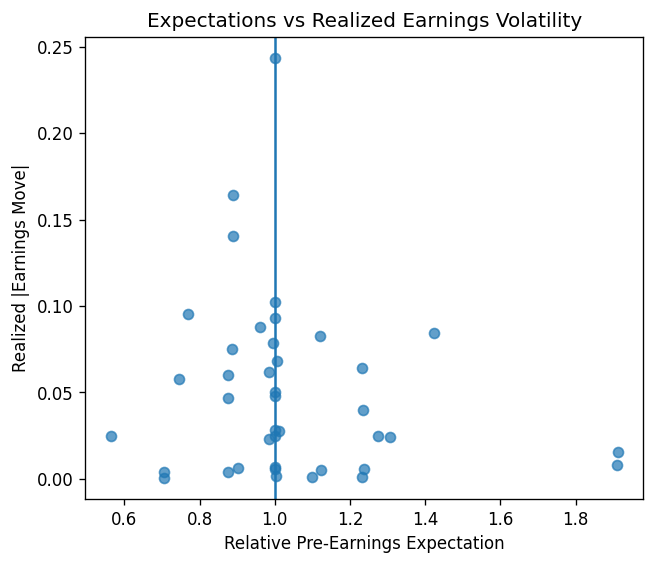

In [30]:
#Expectations vs realized earnings volatility

plt.figure(figsize=(6,5))
plt.scatter(events_df["rel_expectation"], events_df["realized_move"], alpha=0.7)
plt.axvline(1.0)
plt.xlabel("Relative Pre-Earnings Expectation")
plt.ylabel("Realized |Earnings Move|")
plt.title("Expectations vs Realized Earnings Volatility")
plt.show()


Walk-forward MAE: 0.03158319662016128


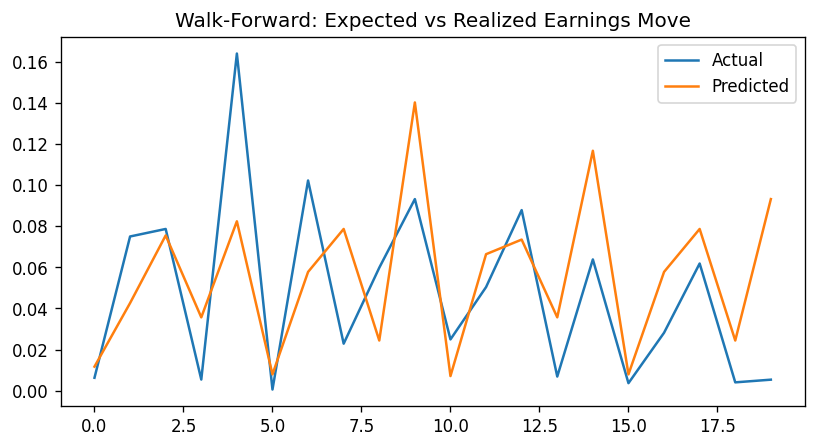

In [31]:
#Walk-forward backtest

from sklearn.metrics import mean_absolute_error

df = events_df.sort_values("earnings_date").copy()

preds = []
truth = []

min_train = 20

for i in range(min_train, len(df)):
    train = df.iloc[:i]
    test = df.iloc[i]

    pred = train[
        train["ticker"] == test["ticker"]
    ]["realized_move"].median()

    preds.append(pred)
    truth.append(test["realized_move"])

mae = mean_absolute_error(truth, preds)

print("Walk-forward MAE:", mae)

plt.figure(figsize=(8,4))
plt.plot(truth, label="Actual")
plt.plot(preds, label="Predicted")
plt.title("Walk-Forward: Expected vs Realized Earnings Move")
plt.legend()
plt.show()
